In [54]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

In [30]:
img  = cv2.imread('./test_images/0eb2230fbf.jpg')

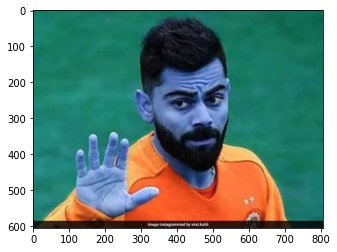

In [31]:
plt.imshow(img)

In [32]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(605, 806)

In [33]:
gray

array([[102, 102, 102, ...,  91,  91,  91],
       [102, 102, 102, ...,  90,  90,  90],
       [102, 102, 102, ...,  90,  90,  90],
       ...,
       [ 19,  18,  17, ...,  21,  21,  21],
       [ 20,  20,  20, ...,  21,  21,  21],
       [ 21,  21,  22, ...,  21,  21,  21]], dtype=uint8)

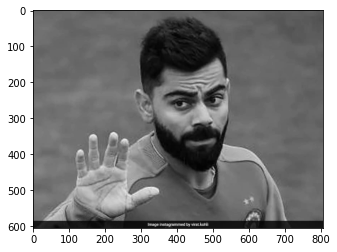

In [34]:
plt.imshow(gray, cmap='gray')

In [35]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[322, 144, 274, 274]])

In [36]:
(x,y,w,h) = faces[0]
x,y,w,h

(322, 144, 274, 274)

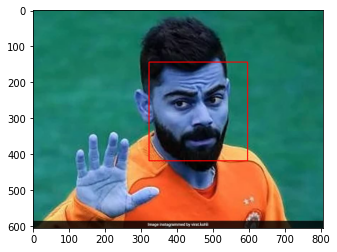

In [37]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

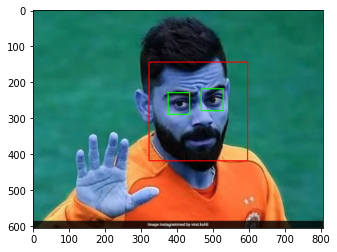

In [38]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

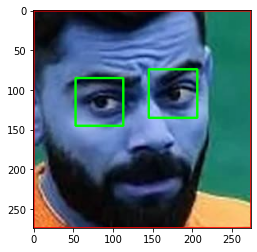

In [39]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [40]:
cropped_img = np.array(roi_color)
cropped_img.shape

(274, 274, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [41]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

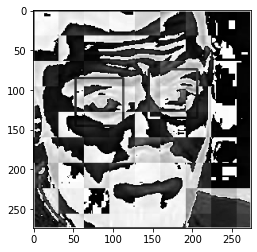

In [42]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [43]:
def cropped_img_if_22_eyes(img_path):
    face_cascade = cv2.CascadeClassifier('./opencv/haarcascade/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('./opencv/haarcascade/haarcascade_eye.xml')
    img = cv2.imread(img_path)
    if img is None:
        return []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    cropped_face=[]
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 0:
            cropped_face.append(roi_color)
    return cropped_face

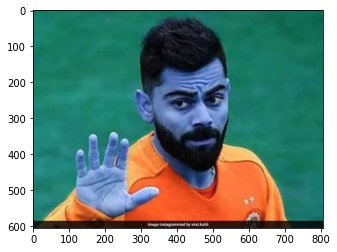

In [44]:
original_image = cv2.imread('./test_images/0eb2230fbf.jpg')
plt.imshow(original_image)

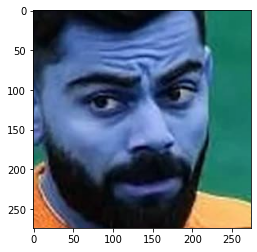

In [45]:
cropped_image = cropped_img_if_22_eyes('./test_images/0eb2230fbf.jpg')[0]
plt.imshow(cropped_image)

#### In below image face is not very clear and it doesn't have two eyes clearly visible

In [46]:
path_to_data = "./images/"
path_to_cr_data = "./images/cropped/"

In [47]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [48]:
img_dirs

['./images/cropped',
 './images/hardik_pandya',
 './images/ishan_kisan',
 './images/jasprit_bumrah',
 './images/kl_rahul',
 './images/kuldeep_yadav',
 './images/md_shami',
 './images/md_siraj',
 './images/ravichandran_ashwin',
 './images/ravindra_jadeja',
 './images/rohit_sharma',
 './images/shardul_thakur',
 './images/shreyas_iyer',
 './images/subhman_gill',
 './images/surya_kumar_yadav',
 './images/virat_kohli']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [49]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [50]:

cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    if celebrity_name=='cropped':
        continue
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = cropped_img_if_22_eyes(entry.path)
        if (len(roi_color)!=0):
            for roi_col in roi_color:
                cropped_folder = path_to_cr_data + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                cropped_file_name = celebrity_name + str(count) + ".png"
                cropped_file_path = cropped_folder + "/" + cropped_file_name
                cv2.imwrite(cropped_file_path, roi_col)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

Generating cropped images in folder:  ./images/cropped/hardik_pandya
Generating cropped images in folder:  ./images/cropped/ishan_kisan
Generating cropped images in folder:  ./images/cropped/jasprit_bumrah
Generating cropped images in folder:  ./images/cropped/kl_rahul
Generating cropped images in folder:  ./images/cropped/kuldeep_yadav
Generating cropped images in folder:  ./images/cropped/md_shami
Generating cropped images in folder:  ./images/cropped/md_siraj
Generating cropped images in folder:  ./images/cropped/ravichandran_ashwin
Generating cropped images in folder:  ./images/cropped/ravindra_jadeja
Generating cropped images in folder:  ./images/cropped/rohit_sharma
Generating cropped images in folder:  ./images/cropped/shardul_thakur
Generating cropped images in folder:  ./images/cropped/shreyas_iyer
Generating cropped images in folder:  ./images/cropped/subhman_gill
Generating cropped images in folder:  ./images/cropped/surya_kumar_yadav
Generating cropped images in folder:  ./

In [59]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'hardik_pandya': ['./images/cropped/hardik_pandya\\hardik_pandya1.png',
  './images/cropped/hardik_pandya\\hardik_pandya11.png',
  './images/cropped/hardik_pandya\\hardik_pandya12.png',
  './images/cropped/hardik_pandya\\hardik_pandya13.png',
  './images/cropped/hardik_pandya\\hardik_pandya15.png',
  './images/cropped/hardik_pandya\\hardik_pandya17.png',
  './images/cropped/hardik_pandya\\hardik_pandya18.png',
  './images/cropped/hardik_pandya\\hardik_pandya19.png',
  './images/cropped/hardik_pandya\\hardik_pandya21.png',
  './images/cropped/hardik_pandya\\hardik_pandya24.png',
  './images/cropped/hardik_pandya\\hardik_pandya25.png',
  './images/cropped/hardik_pandya\\hardik_pandya26.png',
  './images/cropped/hardik_pandya\\hardik_pandya27.png',
  './images/cropped/hardik_pandya\\hardik_pandya28.png',
  './images/cropped/hardik_pandya\\hardik_pandya29.png',
  './images/cropped/hardik_pandya\\hardik_pandya3.png',
  './images/cropped/hardik_pandya\\hardik_pandya30.png',
  './images/crop

In [60]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'hardik_pandya': 0,
 'ishan_kisan': 1,
 'jasprit_bumrah': 2,
 'kl_rahul': 3,
 'kuldeep_yadav': 4,
 'md_shami': 5,
 'md_siraj': 6,
 'ravichandran_ashwin': 7,
 'ravindra_jadeja': 8,
 'rohit_sharma': 9,
 'shardul_thakur': 10,
 'shreyas_iyer': 11,
 'subhman_gill': 12,
 'surya_kumar_yadav': 13,
 'virat_kohli': 14}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [61]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [62]:
len(X[0])

4096

In [63]:
32*32*3 + 32*32

4096

In [64]:
X[0]

array([[36],
       [47],
       [45],
       ...,
       [ 5],
       [ 7],
       [ 4]], dtype=uint8)

In [65]:
y[0]

0

In [66]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(620, 4096)

## Data cleaning process is done. Now we are ready to train our model

In [67]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5225806451612903

In [69]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.60      0.27      0.37        11
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.46      0.67      0.55         9
           5       1.00      0.33      0.50         6
           6       0.62      0.67      0.64        12
           7       0.54      0.70      0.61        10
           8       0.50      0.38      0.43         8
           9       0.50      0.40      0.44         5
          10       0.57      0.67      0.62        18
          11       0.44      0.31      0.36        13
          12       0.70      0.93      0.80        15
          13       1.00      0.33      0.50         6
          14       0.47      0.78      0.58        18

    accuracy                           0.52       155
   macro avg       0.52      0.45      0.45       155
weighted avg       0.53   

C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [71]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [72]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.522581,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.255914,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.533333,{'logisticregression__C': 1}


In [73]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [74]:
best_estimators['svm'].score(X_test,y_test)

0.5419354838709678

In [75]:
best_estimators['random_forest'].score(X_test,y_test)

0.3870967741935484

In [76]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.5548387096774193

In [77]:
best_clf = best_estimators['svm']

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  2,  0,  0,  2],
       [ 0,  3,  0,  0,  0,  0,  0,  4,  0,  0,  1,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  0,  1,  0,  0,  1],
       [ 1,  0,  0,  0,  1,  0,  0,  2,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  4,  0,  3,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  2,  0,  1,  0,  0,  1,  0,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  0,  2,  0,  0,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  1,  1,  0, 12,  0,  0,  0,  1],
       [ 0,  1,  0,  1,  1,  0,  1,  0,  0,  0,  2,  5,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, 13,  0,  0],
       [ 1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  3,  0],
       [ 0,  0,  0,  3,  0,  0,  0

Text(69.0, 0.5, 'Truth')

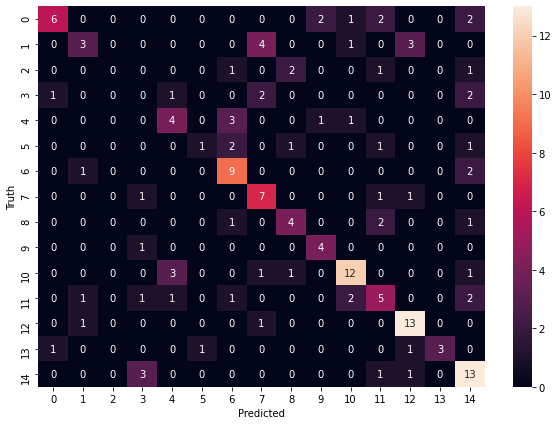

In [79]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [80]:
class_dict

{'hardik_pandya': 0,
 'ishan_kisan': 1,
 'jasprit_bumrah': 2,
 'kl_rahul': 3,
 'kuldeep_yadav': 4,
 'md_shami': 5,
 'md_siraj': 6,
 'ravichandran_ashwin': 7,
 'ravindra_jadeja': 8,
 'rohit_sharma': 9,
 'shardul_thakur': 10,
 'shreyas_iyer': 11,
 'subhman_gill': 12,
 'surya_kumar_yadav': 13,
 'virat_kohli': 14}

### Save the trained model

In [81]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [82]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))